In [1]:
#Mounting your google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/My\ Drive/XAI612

/content/drive/My Drive/XAI612


In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from glob import glob
from tensorflow.python.framework import dtypes
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import pickle

print(tf.__version__)
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'True'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
root_path = os.getcwd()

2.8.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Initial Variables

In [26]:
trainvalid = "retina1_trainvalid/trainvalid"
test = "test_big"
trainvalid_dir = sorted(glob(trainvalid+'/*.jpg'))
test_dir = sorted(glob(test+'/*.*'))
root_path = os.getcwd()
batch_size = 32
img_height = 224
img_width = 224
save_path = root_path + '/saved_model'

### Preprocessing for image_dataset_from_directory
If you done, please pass this.

In [ ]:
y = []
with open("retina1_trainvalid/labels_trainvalid.txt","r") as f:
  labels = f.readlines()
  for line in labels:
    words = line.split()
    y.append(int(words[0]))
print(len(y))

import shutil
if not os.path.exists('retina1_trainvalid/trainvalid/0'):
    os.mkdir('retina1_trainvalid/trainvalid/0')
if not os.path.exists('retina1_trainvalid/trainvalid/1'):
    os.mkdir('retina1_trainvalid/trainvalid/1')

for i in range(len(y)):
  if y[i] == 0:
    shutil.move(trainvalid_dir[i],'retina1_trainvalid/trainvalid/0')
  elif y[i] == 1:
    shutil.move(trainvalid_dir[i],'retina1_trainvalid/trainvalid/1')
  else:
    pass

### Dataloader

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  trainvalid,
  validation_split=0.2,
  subset="training",
  seed=42,
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1179 files belonging to 2 classes.
Using 944 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  trainvalid,
  validation_split=0.2,
  subset="validation",
  seed=42,
  shuffle = False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1179 files belonging to 2 classes.
Using 235 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['0', '1']


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test,
  label_mode = None,
  image_size=(img_height, img_width),
  shuffle = False
  )

Found 67 files belonging to 1 classes.


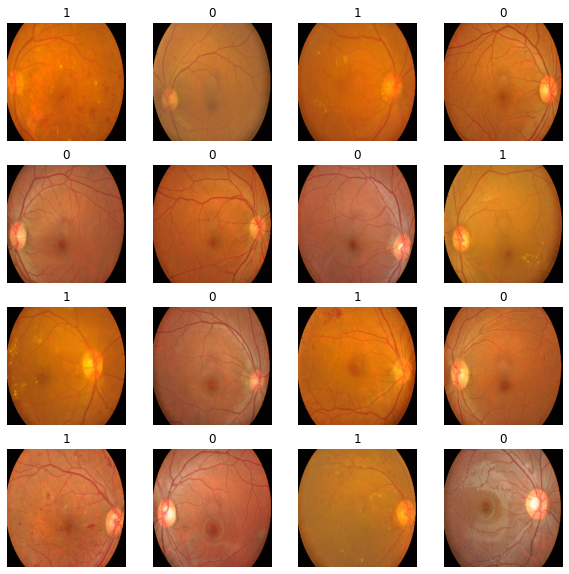

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

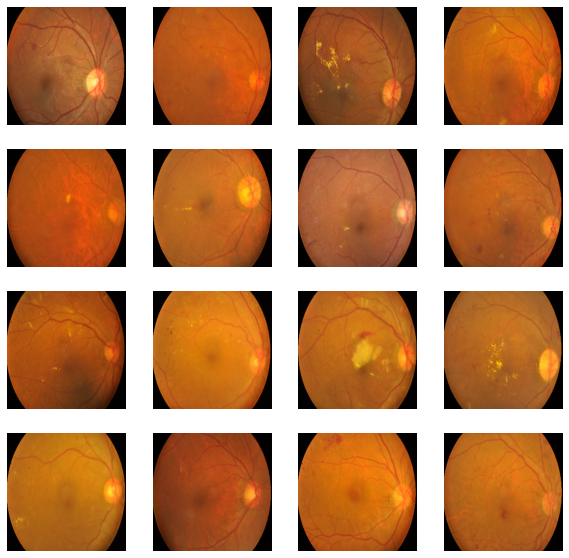

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in val_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

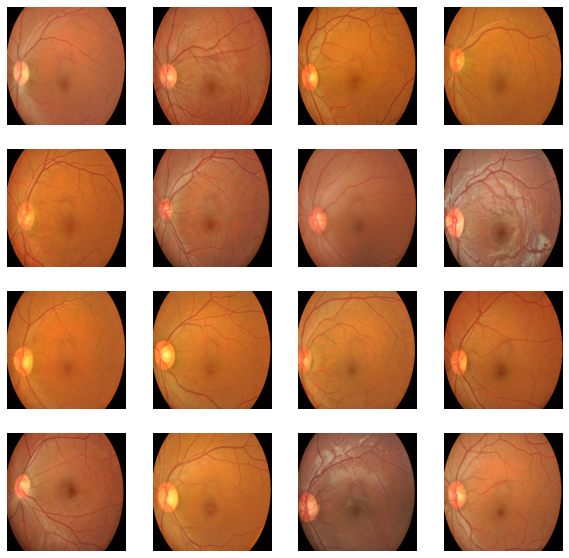

In [11]:
plt.figure(figsize=(10, 10))
for images in test_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

### Normalization and Augmentation

In [12]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
augmentation_layer = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"), ## Horizontal Flip
  tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.15, 0.15)), ## Random Rotation
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.0, 0.3),width_factor=(0.0, 0.3)), ## Random Zoom
  normalization_layer,  
]
)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (augmentation_layer(x), y),num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y),num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x: normalization_layer(x),num_parallel_calls=AUTOTUNE)

### Model

In [13]:
import tensorflow as tf
from tensorflow.keras import layers

In [14]:
def identity_block(input_tensor, filters, strides=1):
  """
  input tensor
  filters: a tuple of 3 filters to be used in convolutional layers
  strides = 1 for all conv layers
  """
  f1, f2, f3 = filters

  x = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=strides)(input_tensor)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=strides, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=strides)(x)
  x = layers.BatchNormalization()(x)
  
  x = layers.Add()([x, input_tensor])
  output_tensor = layers.ReLU()(x)

  return output_tensor

In [15]:
def projection_block(input_tensor, filters, strides=2):
  """
  A projection block is a block that has 1x1 conv layer in the shortcut connection
  1x1 convolution at shortcut connection is used for increasing the input dimension.
  input_tensor: input tensor
  filters: a tuple of 3 filters to be used in 3 conv layers at the main path, the 1x1conv shortcut takes third filter
  strides of 2 at the first conv layers in conv block conv3_1, conv4_1, and conv5_1 for downsampling purpose
  """

  f1, f2, f3 = filters
  x = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=strides)(input_tensor)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=1, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=1)(x)
  x = layers.BatchNormalization()(x)

  # 1x1 conv projection shortcut
  shortcut = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=strides)(input_tensor)
  shortcut = layers.BatchNormalization()(shortcut)

  x = layers.Add()([x, shortcut])
  output_tensor = layers.ReLU()(x)

  return output_tensor

In [16]:
def ResNet50(h = 224, w = 224, c = 3):
    input = layers.Input(shape=(h, w, c))

    x = layers.Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    x = projection_block(x, (64, 64, 256))
    x = identity_block(x, (64, 64, 256))
    x = identity_block(x, (64, 64, 256))

    x = projection_block(x, (128, 128, 512))
    x = identity_block(x, (128, 128, 512))
    x = identity_block(x, (128, 128, 512))
    x = identity_block(x, (128, 128, 512))

    x = projection_block(x, (256, 256, 1024))
    x = identity_block(x, (256, 256, 1024))
    x = identity_block(x, (256, 256, 1024))
    x = identity_block(x, (256, 256, 1024))
    x = identity_block(x, (256, 256, 1024))
    x = identity_block(x, (256, 256, 1024))

    x = projection_block(x, (512, 512, 2048))
    x = identity_block(x, (512, 512, 2048))
    x = identity_block(x, (512, 512, 2048))

    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(2, activation='softmax')(x)

    return tf.keras.Model(input, x, name='ResNet-50')

### **Training**

##### **Optimizer**

In [21]:
## Optimizer and schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)  
optimizer = tf.keras.optimizers.SGD(learning_rate = lr_schedule, momentum = 0.9, decay = 0.0005)
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False)

##### **Checkpoint and earlystopp**
Since initial training is unstable, set up wait point for checkpoint and earlystop until 100 epochs

In [18]:
## Custom stopper with start epoch
class CustomStopper(EarlyStopping):
    def __init__(self, start_epoch, **kwargs): # add argument for starting epoch
        super(CustomStopper, self).__init__(**kwargs)
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch >= self.start_epoch:
            super().on_epoch_end(epoch, logs)

## Custom stopper with start epoch
class CustomCheckpoint(ModelCheckpoint):
    def __init__(self, filepath, start_epoch, **kwargs): # add argument for starting epoch
        super(CustomCheckpoint, self).__init__(filepath,**kwargs)
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch >= self.start_epoch:
            super().on_epoch_end(epoch, logs)

modelPath = os.path.join(save_path, 'bestModel.h5')
checkpoint = CustomCheckpoint( # set model saving checkpoints
    modelPath, # set path to save model weights
    monitor='val_loss', # set monitor metrics
    verbose=1, # set training verbosity
    save_best_only=True, # set if want to save only best weights
    save_weights_only=True, # set if you want to save only model weights
    mode='auto', # set if save min or max in metrics
    period=1, # interval between checkpoints
    start_epoch=100 # Checkpoint after start_epochs
    )

earlystopping = CustomStopper(
  monitor='val_loss', # set monitor metrics
  min_delta=0.001, # set minimum metrics delta
  patience=30, # number of epochs to stop training
  restore_best_weights=True, # set if use best weights or last weights
  start_epoch=100 # Check patience after start_epochs
  )  

callbacksList = [checkpoint, earlystopping]

##### **Model**

In [22]:
model = ResNet50(img_height, img_width, 3)
model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=['accuracy'])

In [23]:
hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=300,
  callbacks=callbacksList
)
with open(os.path.join(save_path, "hist.pkl"), "wb") as file:
    pickle.dump(hist.history, file)
model.save(save_path)

Epoch 1/300
30/30 [==============================] - 35s 859ms/step - loss: 1.0956 - accuracy: 0.5350 - val_loss: 0.8122 - val_accuracy: 0.0043
Epoch 2/300
30/30 [==============================] - 28s 781ms/step - loss: 0.7462 - accuracy: 0.6981 - val_loss: 0.6369 - val_accuracy: 0.8426
Epoch 3/300
30/30 [==============================] - 28s 777ms/step - loss: 0.6314 - accuracy: 0.7331 - val_loss: 0.8548 - val_accuracy: 0.0000e+00
Epoch 4/300
30/30 [==============================] - 28s 797ms/step - loss: 0.6539 - accuracy: 0.7574 - val_loss: 0.6274 - val_accuracy: 0.8979
Epoch 5/300
30/30 [==============================] - 28s 797ms/step - loss: 0.5552 - accuracy: 0.7659 - val_loss: 0.6892 - val_accuracy: 0.6170
Epoch 6/300
30/30 [==============================] - 28s 795ms/step - loss: 0.6007 - accuracy: 0.7722 - val_loss: 0.7879 - val_accuracy: 0.1489
Epoch 7/300
30/30 [==============================] - 28s 787ms/step - loss: 0.5700 - accuracy: 0.7659 - val_loss: 1.4390 - val_accur

### Test

In [27]:
del model # Delete the original model, just to be sure!
model = tf.keras.models.load_model(save_path, custom_objects={"CustomModel": ResNet50})
prob = model.predict(test_ds)
prediction = np.argmax(prob, axis = 1)
print(prediction)

[0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1]


In [29]:
import pandas as pd
submission = pd.DataFrame({
  'id':test_dir,
  'prediction':prediction
})
submission.to_csv('submission.csv',index = False)

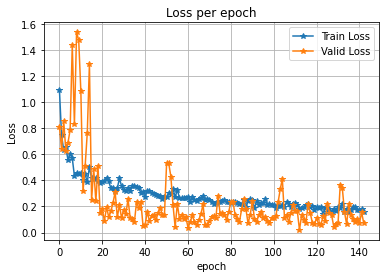

In [34]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='Train Loss', marker='*')
plt.plot(hist.history['val_loss'], label='Valid Loss', marker='*')
plt.title('Loss per epoch');
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()

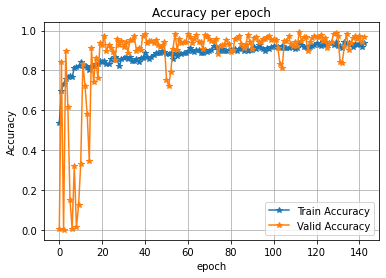

In [35]:
plt.plot(hist.history['accuracy'], label='Train Accuracy', marker='*')
plt.plot(hist.history['val_accuracy'], label='Valid Accuracy', marker='*')
plt.title('Accuracy per epoch');
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()